# Connectome-constrained visual system model

**Summary**: In this tutorial, we will demonstrate how to integrate a connectome-constrained visual system model [(Lappalainen et al., 2023)](https://www.biorxiv.org/content/10.1101/2023.03.11.532232) into NeuroMechFly. We will simulate a scenario where a stationary fly observes another fly walking in front of it and examine the responses of different classes of neurons in the visual system.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from flygym import Camera, Simulation
from flygym.examples.locomotion import HybridTurningFly
from flygym.examples.vision.realistic_vision_fly import RealisticVisionFly

(-0.5, 639.5, 479.5, -0.5)

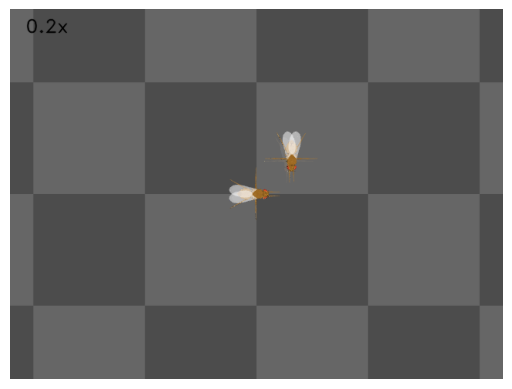

In [2]:
timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

target = HybridTurningFly(
    name="target",
    enable_adhesion=True,
    draw_adhesion=True,
    contact_sensor_placements=contact_sensor_placements,
    seed=0,
    draw_corrections=True,
    timestep=timestep,
    spawn_pos=(3, 3, 0.5),
    spawn_orientation=(0, 0, 0),
)

observer = RealisticVisionFly(
    name="observer",
    spawn_pos=(0, 0, 0.5),
    spawn_orientation=(0, 0, np.pi / 2),
    contact_sensor_placements=contact_sensor_placements,
    head_stabilization_model="thorax",
)

cam = Camera(
    fly=observer,
    camera_id="Animat/camera_top_zoomout",
)

sim = Simulation(
    flies=[observer, target],
    cameras=[cam],
    timestep=timestep,
)

im = sim.render()[0]

fig, ax = plt.subplots()
ax.imshow(im)
ax.axis("off")

In [3]:
obs, info = sim.reset(seed=0)
viz_data_all = []

for i in trange(10000):
    obs, _, _, _, info = sim.step(
        {
            "observer": np.zeros(2),  # stand still
            "target": np.ones(2),  # walk forward
        }
    )

    rendered_img = sim.render()[0]

    if rendered_img is not None:
        viz_data = {
            "rendered_image": rendered_img,
            "vision_observation": obs["observer"]["vision"],
            "nn_activities": info["observer"]["nn_activities"],
        }
        viz_data_all.append(viz_data)

    if obs["target"]["fly"][0, 1] < -3:
        break

We can visualize activites of different classes of neurons along with the ommatidia readings and the top-view rendering using the provided `visualize_vision` function:

In [ ]:
from flygym.examples.vision import RetinaMapper
from flygym.examples.vision.viz import visualize_vision
from flygym.vision import Retina

visualize_vision(
    "temp2.mp4",
    Retina(),
    RetinaMapper(),
    viz_data_all[:10],
    fps=cam.fps,
)
plt.close()